In [1]:
# IMPORTS 
##########
##########

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from astropy.visualization import hist
from astropy.stats import histogram, sigma_clip
from astropy.io import fits
import astropy.units as u

import ccdproc
from ccdproc import subtract_overscan
from ccdproc import trim_image
from ccdproc import CCDData

import sys
sys.path.insert(0,'./ccd_red_notebooks/ccd-reduction-and-photometry-guide/notebooks/')
from convenience_functions import show_image

In [2]:
#CLD this cell contains the path to images in my home dir. change to access images in your dir
path = '../../../../imaging/reduced_data/'

# Problem 1

The V flats do contian significant artifacts, namely stars. As these flats have been dithered, by clipping, or removing, the deviations between flats created by these artifacts and then combining in a sufficient way, you should be able to remove the artificats entirely. 

In [3]:
#CLD loading in the V band flats which are images 43-49
flats = []
for i in range(49-43+1):
    data = fits.getdata(path+'a0'+str(i+43)+'otb.fits')
    flats.append(data)

In [4]:
#CLD comparing the mean light level in all the flats
for flat in flats:
    print(np.mean(flat))

9190.49680293932
16304.433626307384
28043.21626652613
24054.18940366639
34694.82779110807
29648.522413624672
25736.489274634267


The average light level of the flights is highly variable throughout the night. It increases steadily and then has a slight decrease when you get to the last one. As you want to a common base to compare the flats against, you are going to have to scale all of them to a common mean. Additionally, when combining, you want to add greatest value to the flats with the highest signal to noise, meaning the flats with the highest mean level. To do this, weight the flats based on their highest counts when combining.

In [5]:
#CLD I think I want to scale the flats to their highest means, ie normalize each flat before combining?
i = 0
for flat in flats:
    flat = flat/np.mean(flat)
    flats[i] = flat
    i+=1

In [6]:
#CLD now comparing the different combination stratigies. Will first be doing all of the combines (except the last one)
#CLD and compare the rms/plots of the master flats
flats_ccd = []
for i in range(len(flats)):
    ccd = CCDData(flats[i], unit=u.adu)
    flats_ccd.append(ccd)

avg = ccdproc.combine(flats_ccd, method='average')
median = ccdproc.combine(flats_ccd, method='median')
avg_3sig = ccdproc.combine(flats_ccd, method='average', sigma_clipping=True)
med_3sig = ccdproc.combine(flats_ccd, method='median', sigma_clipping=True)

0.015508520098670524


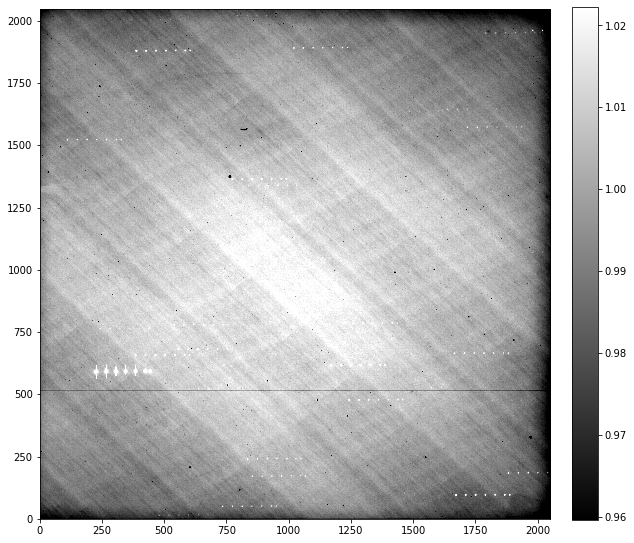

In [7]:
#CLD the average combine
show_image(avg, cmap='gray')
print(np.std(avg))

0.015508520098670524


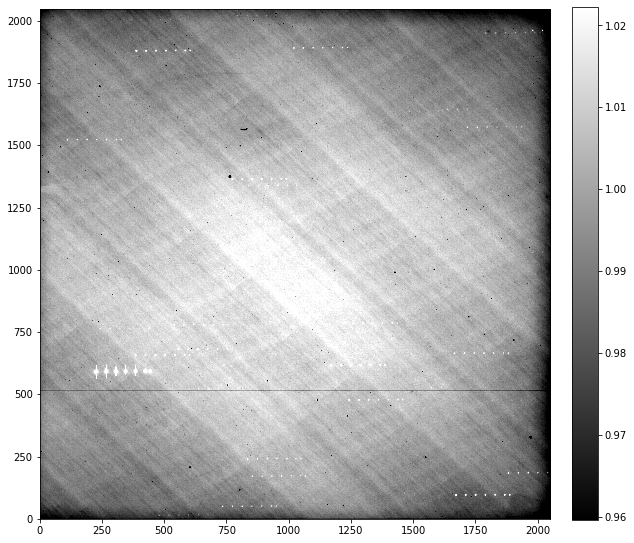

In [8]:
#CLD the avg combine with 3sig clipping
show_image(avg_3sig, cmap='gray')
print(np.std(avg_3sig))

0.01455483933439435


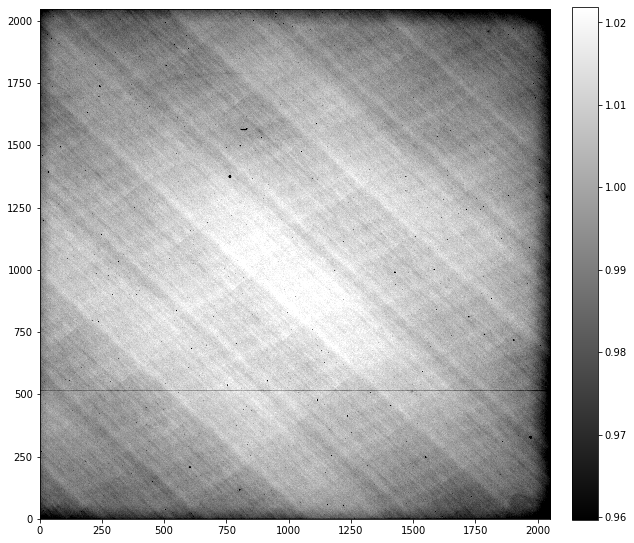

In [9]:
#CLD the median combine
show_image(median, cmap='gray')
print(np.std(median))

0.01455483933439435


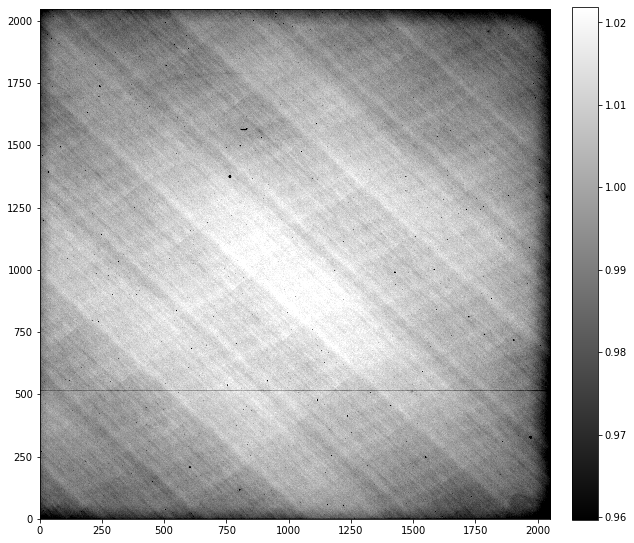

In [10]:
#CLD the median combine with 3sig clipping
show_image(med_3sig, cmap='gray')
print(np.std(med_3sig))

The average combine and the average combine with 3 sigma clipping have almost no difference as seen in the consistency of standard devitation values. Additionally, these combination techniques do not remove the artifacts at all. However, the median combine does remove artifacts and has a lower standard deviation overall, although not by a huge amount. As far as these comparisons go, the median combination technique is the best. 

To do the last combination technique, I need to write my own function in order to sigma clip at a threshold less than three and calculate the weighted mean. To do this, I will sigma clip each image myself using the sigma clip astropy function and then pass the weights to a numpy function that does weighted averaging. From class, it is known that a threshold of 2 is an appropriate level to sigma clip at.

In [11]:
def weighted_combine(flat_data, thresh, method='average'):
    
    #CLD want to calculate the weights for each image before sigma clipping
    weights = []
    for data in flat_data:
        weight = np.mean(data)
        weights.append(weight)
        
    weights = np.asarray(weights) #CLD must be np array for ccdproc.combine
    
    #CLD first running the sigma clipping procedure
    for i in range(len(flat_data)):
        flat_data[i] = flat_data[i] / np.mean(flat_data[i])
    
    clipped = sigma_clip(flat_data, sigma=thresh, axis=0)

    #CLD combining use the set method
    #CLD default method is average but can also take median
    master = np.ma.average(clipped, weights=weights, axis=0)
    
    return master

In [12]:
#CLD running the above procedure to sigma clip and weighted average combine the flats list
weighted_avg_2sig = weighted_combine(flats, 2)

0.014533579021026847


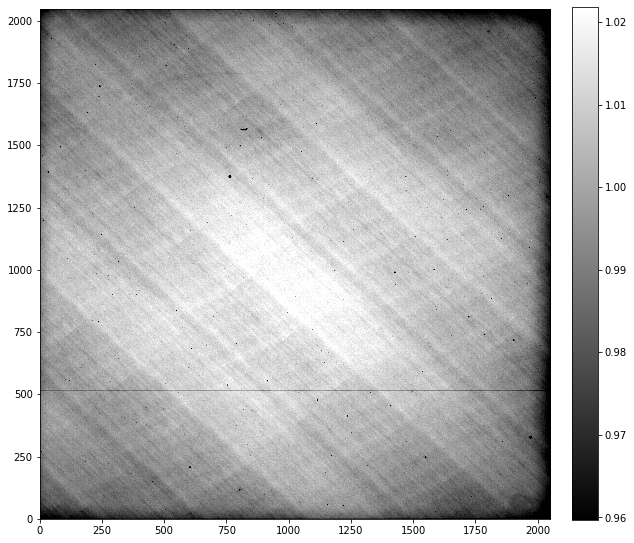

In [13]:
show_image(weighted_avg_2sig, cmap='gray')
print(np.std(weighted_avg_2sig))

The weighted average combine with 2 sigma clipping has the lowest RMS over all, but barely. It honestly might be easier to just do a median combine for all the flats but since I went through the trouble of writing my own function I'll use it.

# Problem 2

I will preform the above procedure for all flats in H-alpha (005-020), U (21-28), B (29-42), V (43-49), R (50-55), I (57-62). Will be discounting a056 as it is labeld as bad in the log.

In [14]:
h_flats = []
for i in range(20-5+1):
    if i<5:
        data = fits.getdata(path+'a00'+str(i+5)+'otb.fits')
        h_flats.append(data)
    if i>=5:
        data = fits.getdata(path+'a0'+str(i+5)+'otb.fits')
        h_flats.append(data)
    
u_flats = []
for i in range(28-21+1):
    data = fits.getdata(path+'a0'+str(i+21)+'otb.fits')
    u_flats.append(data)
    
b_flats = []
for i in range(42-29+1):
    data = fits.getdata(path+'a0'+str(i+29)+'otb.fits')
    b_flats.append(data)
    
v_flats = []
for i in range(49-43+1):
    data = fits.getdata(path+'a0'+str(i+43)+'otb.fits')
    v_flats.append(data)
    
r_flats = []
for i in range(55-50+1):
    data = fits.getdata(path+'a0'+str(i+50)+'otb.fits')
    r_flats.append(data)
    
i_flats = []
for i in range(62-57+1):
    data = fits.getdata(path+'a0'+str(i+57)+'otb.fits')
    i_flats.append(data)

In [15]:
#CLD making the master flat for all of the filters by running the weighted avg function from above
master_h = weighted_combine(h_flats, 2)
master_u = weighted_combine(u_flats, 2)
master_b = weighted_combine(b_flats, 2)
master_v = weighted_combine(v_flats, 2)
master_r = weighted_combine(r_flats, 2)
master_i = weighted_combine(i_flats, 2)

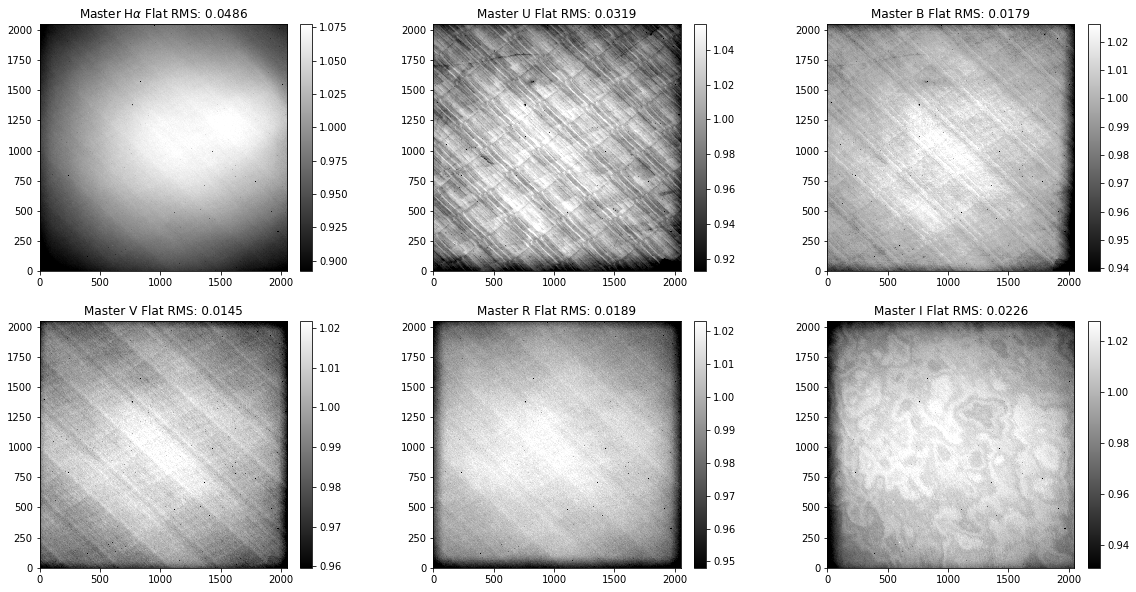

In [312]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0].set_title(r'Master H$\alpha$ Flat RMS: %.4f' %(np.std(master_h)))
ax[0,1].set_title(r'Master U Flat RMS: %.4f' %(np.std(master_u)))
ax[0,2].set_title(r'Master B Flat RMS: %.4f' %(np.std(master_b)))
ax[1,0].set_title(r'Master V Flat RMS: %.4f' %(np.std(master_v)))
ax[1,1].set_title(r'Master R Flat RMS: %.4f' %(np.std(master_r)))
ax[1,2].set_title(r'Master I Flat RMS: %.4f' %(np.std(master_i)))
show_image(master_h, cmap='gray', ax=ax[0,0], fig=fig,)
show_image(master_u, cmap='gray', ax=ax[0,1], fig=fig,)
show_image(master_b, cmap='gray', ax=ax[0,2], fig=fig,)
show_image(master_v, cmap='gray', ax=ax[1,0], fig=fig,)
show_image(master_r, cmap='gray', ax=ax[1,1], fig=fig,)
show_image(master_i, cmap='gray', ax=ax[1,2], fig=fig,)

# Problem 3

In [16]:
#CLD normalizing the master flats by their mean value
norm_master_h = master_h / np.mean(master_h)
norm_master_u = master_u / np.mean(master_u)
norm_master_b = master_b / np.mean(master_b)
norm_master_v = master_v / np.mean(master_v)
norm_master_r = master_r / np.mean(master_r)
norm_master_i = master_i / np.mean(master_i)

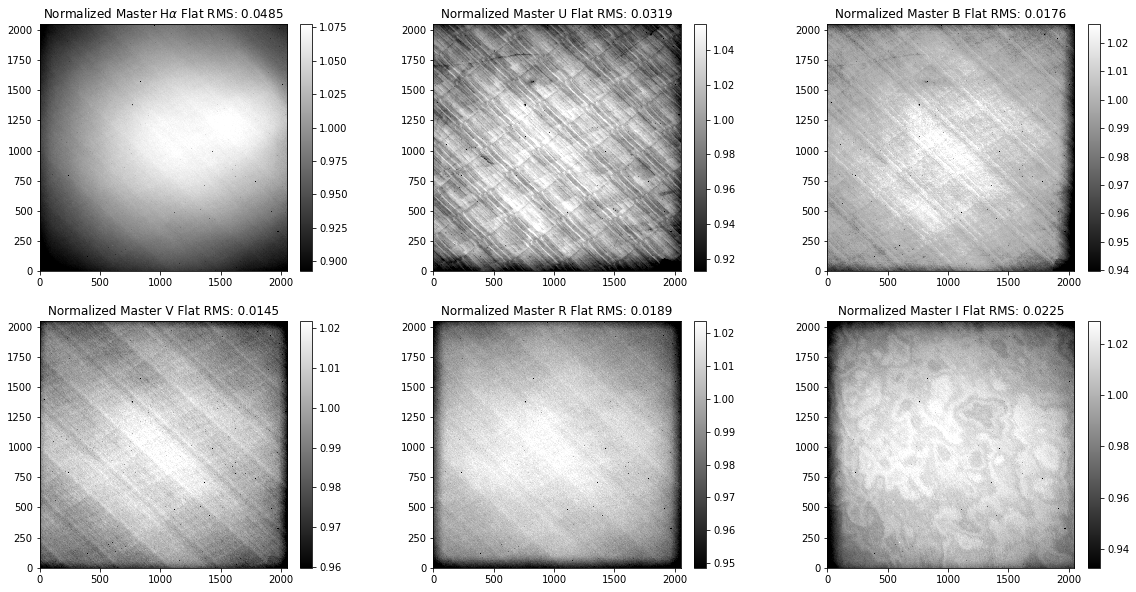

In [216]:
#CLD printing out these images just to make sure nothing went wrong
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0].set_title(r'Normalized Master H$\alpha$ Flat RMS: %.4f' %(np.std(norm_master_h)))
ax[0,1].set_title(r'Normalized Master U Flat RMS: %.4f' %(np.std(norm_master_u)))
ax[0,2].set_title(r'Normalized Master B Flat RMS: %.4f' %(np.std(norm_master_b)))
ax[1,0].set_title(r'Normalized Master V Flat RMS: %.4f' %(np.std(norm_master_v)))
ax[1,1].set_title(r'Normalized Master R Flat RMS: %.4f' %(np.std(norm_master_r)))
ax[1,2].set_title(r'Normalized Master I Flat RMS: %.4f' %(np.std(norm_master_i)))
show_image(norm_master_h, cmap='gray', ax=ax[0,0], fig=fig,)
show_image(norm_master_u, cmap='gray', ax=ax[0,1], fig=fig,)
show_image(norm_master_b, cmap='gray', ax=ax[0,2], fig=fig,)
show_image(norm_master_v, cmap='gray', ax=ax[1,0], fig=fig,)
show_image(norm_master_r, cmap='gray', ax=ax[1,1], fig=fig,)
show_image(norm_master_i, cmap='gray', ax=ax[1,2], fig=fig,)

Nothing really changed but will check the means real quick.

In [17]:
norm_master_h = np.asarray(norm_master_h)
norm_master_u = np.asarray(norm_master_u)
norm_master_b = np.asarray(norm_master_b)
norm_master_v = np.asarray(norm_master_v)
norm_master_r = np.asarray(norm_master_r)
norm_master_i = np.asarray(norm_master_i)

print(np.mean(norm_master_h))
print(np.mean(norm_master_u))
print(np.mean(norm_master_b))
print(np.mean(norm_master_v))
print(np.mean(norm_master_r))
print(np.mean(norm_master_i))

0.9999999999999993
0.9999999999999992
1.0000000000000009
0.9999999999999996
1.0000000000000002
1.0000000000000002


By python standards, these flats are normalized.

In [224]:
#CLD saving the master flats unnormalized
master_h = np.asarray(master_h)
master_u = np.asarray(master_u)
master_b = np.asarray(master_b)
master_v = np.asarray(master_v)
master_r = np.asarray(master_r)
master_i = np.asarray(master_i)

fits.writeto(path+'master_h.fits', master_h, overwrite=True)
fits.writeto(path+'master_u.fits', master_u, overwrite=True)
fits.writeto(path+'master_b.fits', master_b, overwrite=True)
fits.writeto(path+'master_v.fits', master_v, overwrite=True)
fits.writeto(path+'master_r.fits', master_r, overwrite=True)
fits.writeto(path+'master_i.fits', master_i, overwrite=True)

# Problem 4

In [231]:
#CLD will now be dividng each science by the normalized master flat that corresponds to the filter the
#CLD science was taken in
#CLD last notebook I did the sciences through 74-151 so will be doing that again
                #CLD 74-80 V
        #CLD 81, 82 U
            #CLD 83, 84 B
                #CLD 85, 86 V
                    #CLD 87, 88 R
                        #CLD 89, 90 I
    #CLD 91, 92 H
            #CLD 112-114 B
                #CLD 115-120 V
                    #CLD 121-123 R
                        #CLD 124-126 I
    #CLD 127-129 H
        #CLD 130, 131 U
            #CLD 132, 133 B
                #CLD 134m 135 V
                    #CLD 136, 137 R
                        #CLD 138, 139 I
                        #CLD 142, 143 I
                    #CLD 144,145, R
                #CLD 146, 147 V
            #CLD 148, 149 B
        #CLD 150, 151 U
#CLD I think I'm just going to hard code these by filter bc like most of these are two images and not worth writing a 
#CLD for loop for

#CLD starting off with the h filter
data = fits.getdata(path+"a091otb.fits")
data = data / norm_master_h
fits.writeto(path+"a091otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a092otb.fits")
data = data / norm_master_h
fits.writeto(path+"a092otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a127otb.fits")
data = data / norm_master_h
fits.writeto(path+"a127otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a128otb.fits")
data = data / norm_master_h
fits.writeto(path+"a128otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a129otb.fits")
data = data / norm_master_h
fits.writeto(path+"a129otbf.fits", data, overwrite=True)

In [232]:
#CLD doing the U filter images
data = fits.getdata(path+"a081otb.fits")
data = data / norm_master_u
fits.writeto(path+"a081otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a082otb.fits")
data = data / norm_master_u
fits.writeto(path+"a082otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a130otb.fits")
data = data / norm_master_u
fits.writeto(path+"a130otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a131otb.fits")
data = data / norm_master_u
fits.writeto(path+"a131otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a150otb.fits")
data = data / norm_master_u
fits.writeto(path+"a150otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a151otb.fits")
data = data / norm_master_u
fits.writeto(path+"a151otbf.fits", data, overwrite=True)

In [234]:
#CLD doing the B filter images
data = fits.getdata(path+"a083otb.fits")
data = data / norm_master_b
fits.writeto(path+"a083otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a084otb.fits")
data = data / norm_master_b
fits.writeto(path+"a084otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a112otb.fits")
data = data / norm_master_b
fits.writeto(path+"a112otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a113otb.fits")
data = data / norm_master_b
fits.writeto(path+"a113otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a114otb.fits")
data = data / norm_master_b
fits.writeto(path+"a114otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a132otb.fits")
data = data / norm_master_b
fits.writeto(path+"a132otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a133otb.fits")
data = data / norm_master_b
fits.writeto(path+"a133otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a148otb.fits")
data = data / norm_master_b
fits.writeto(path+"a148otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a149otb.fits")
data = data / norm_master_b
fits.writeto(path+"a149otbf.fits", data, overwrite=True)

In [235]:
#CLD doing the V filters
#CLD 74-80, 85, 86, 115-120, 134, 135, 146, 147

data = fits.getdata(path+"a074otb.fits")
data = data / norm_master_v
fits.writeto(path+"a074otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a075otb.fits")
data = data / norm_master_v
fits.writeto(path+"a075otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a076otb.fits")
data = data / norm_master_v
fits.writeto(path+"a076otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a077otb.fits")
data = data / norm_master_v
fits.writeto(path+"a077otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a078otb.fits")
data = data / norm_master_v
fits.writeto(path+"a078otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a079otb.fits")
data = data / norm_master_v
fits.writeto(path+"a079otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a080otb.fits")
data = data / norm_master_v
fits.writeto(path+"a080otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a085otb.fits")
data = data / norm_master_v
fits.writeto(path+"a085otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a086otb.fits")
data = data / norm_master_v
fits.writeto(path+"a086otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a115otb.fits")
data = data / norm_master_v
fits.writeto(path+"a115otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a116otb.fits")
data = data / norm_master_v
fits.writeto(path+"a116otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a117otb.fits")
data = data / norm_master_v
fits.writeto(path+"a117otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a118otb.fits")
data = data / norm_master_v
fits.writeto(path+"a118otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a119otb.fits")
data = data / norm_master_v
fits.writeto(path+"a119otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a120otb.fits")
data = data / norm_master_v
fits.writeto(path+"a120otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a134otb.fits")
data = data / norm_master_v
fits.writeto(path+"a134otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a135otb.fits")
data = data / norm_master_v
fits.writeto(path+"a135otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a146otb.fits")
data = data / norm_master_v
fits.writeto(path+"a146otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a147otb.fits")
data = data / norm_master_v
fits.writeto(path+"a147otbf.fits", data, overwrite=True)

In [237]:
#CLD doing all of the r sciences 
#CLD 87, 88, 121, 122, 123, 136, 137, 144, 145
data = fits.getdata(path+"a087otb.fits")
data = data / norm_master_r
fits.writeto(path+"a087otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a088otb.fits")
data = data / norm_master_r
fits.writeto(path+"a088otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a121otb.fits")
data = data / norm_master_r
fits.writeto(path+"a121otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a122otb.fits")
data = data / norm_master_r
fits.writeto(path+"a122otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a123otb.fits")
data = data / norm_master_r
fits.writeto(path+"a123otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a136otb.fits")
data = data / norm_master_r
fits.writeto(path+"a136otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a137otb.fits")
data = data / norm_master_r
fits.writeto(path+"a137otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a144otb.fits")
data = data / norm_master_r
fits.writeto(path+"a144otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a145otb.fits")
data = data / norm_master_r
fits.writeto(path+"a145otbf.fits", data, overwrite=True)

In [238]:
#CLD doing all of the i science frames
#CLD 89, 90, 124, 126, 138, 139, 142, 143
data = fits.getdata(path+"a089otb.fits")
data = data / norm_master_i
fits.writeto(path+"a089otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a090otb.fits")
data = data / norm_master_i
fits.writeto(path+"a090otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a124otb.fits")
data = data / norm_master_i
fits.writeto(path+"a124otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a126otb.fits")
data = data / norm_master_i
fits.writeto(path+"a126otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a138otb.fits")
data = data / norm_master_i
fits.writeto(path+"a138otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a139otb.fits")
data = data / norm_master_i
fits.writeto(path+"a139otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a142otb.fits")
data = data / norm_master_i
fits.writeto(path+"a142otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a143otb.fits")
data = data / norm_master_i
fits.writeto(path+"a143otbf.fits", data, overwrite=True)

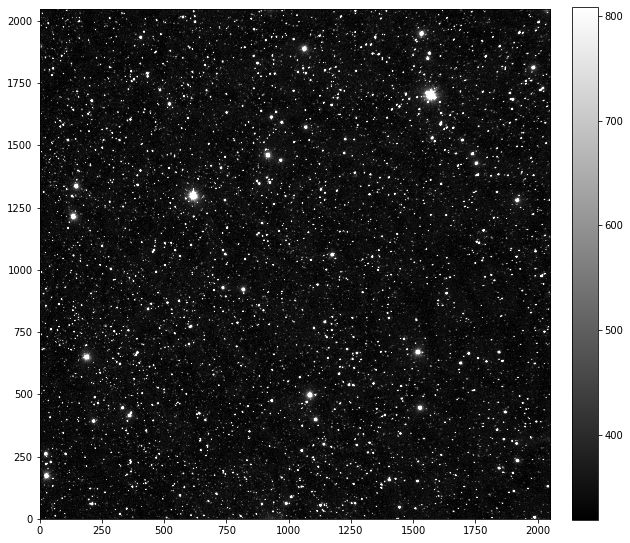

In [241]:
#CLD doing a quick visual check to make sure no random patterns appeared
data = fits.getdata(path+"a143otbf.fits")
show_image(data, cmap='gray')

The above quick visual check looks pretty good to me. Also, I realized most of the way through the above that it probably would have been faster/looked nicer to make a list of the numbers of data for each science and then like loop over that list, but I subscribed to a sunk cost fallacy and decided to just finish out what I was already doing.

# Problem 5

From Howell pg73 (Chapter 4.3), the gain of a CCD can be calculated using two flat fielded flats and two bias images. The gain is caluclted by subtracting the joint mean of the biases from the joint mean of the flats and then dividing by the differences in the square standard deviations from the two sets of images. In other words:

$G = \frac{(\bar{F_{1}} + \bar{F_{2}}) - (\bar{B_{1}} + \bar{B_{2}})}{\sigma^{2}_{F_{1,2}} - \sigma^{2}_{B_{1,2}}}$

To do this, you will most likely want to look at areas of the flat that lack stars and the area of the bias that is not dominated by the pattern in the middle. This is because gain is an intrinsic quality of the CCD, so we do not want contimaition either from other sources (the stars in the flat) or patterns that would repersent other things happening in the CCD (the pattern in the bias down the center).

To choose these regions, I will open each flat/bias image I intend to use and visually inspect for an appropriate region.

Additionally, I need to use flats that have been flat fielded by a normalized flat for the reasons stated in the homework.

In [268]:
#CLD for the flats I will be using flat 44 and 45
#CLD for the biases I will be using 94 and 95
#CLD my choice of these is pretty arbitrary as it shouldnt matter what flats/biases you use

flat1 = fits.getdata(path+'a044otb.fits')
flat2 = fits.getdata(path+'a045otb.fits')

flat1 = flat1 / norm_master_v #CLD both chosen flats lie in the V filter
flat2 = flat2 / norm_master_v

bias1 = fits.getdata(path+'a100ot.fits')
bias2 = fits.getdata(path+'a095ot.fits')

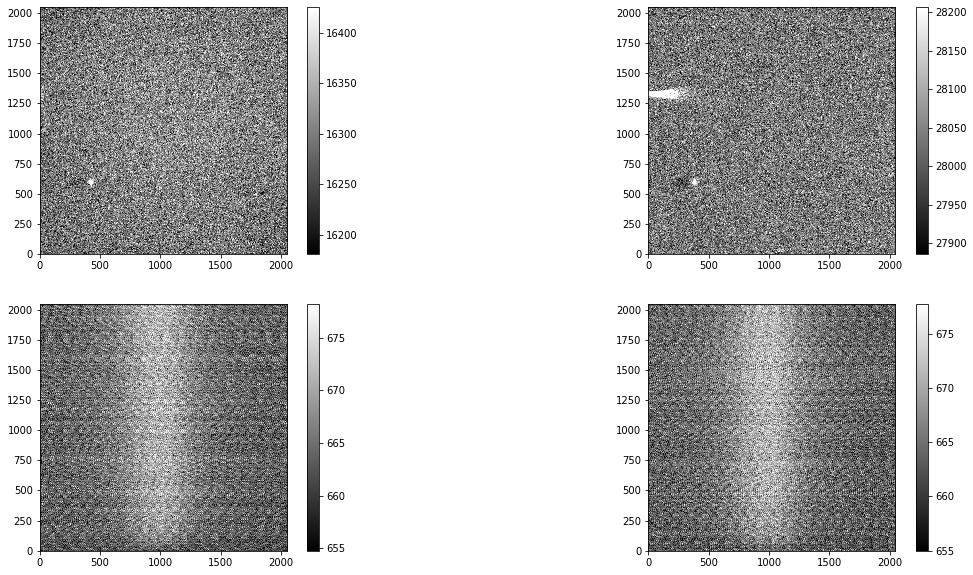

In [269]:
#CLD plotting the chosen flats and biases
fig, ax = plt.subplots(2,2, figsize=(20,10))
show_image(flat1, cmap='gray', ax=ax[0,0], fig=fig)
show_image(flat2, cmap='gray', ax=ax[0,1], fig=fig)
show_image(bias1, cmap='gray', ax=ax[1,0], fig=fig)
show_image(bias2, cmap='gray', ax=ax[1,1], fig=fig)
plt.show(fig)

For both flats, a region of x=[1000,1250] and y=[1000,1250] should suffice. For both biases, a region of x=[1750,2000] and y=[1750,2000] should suffice.

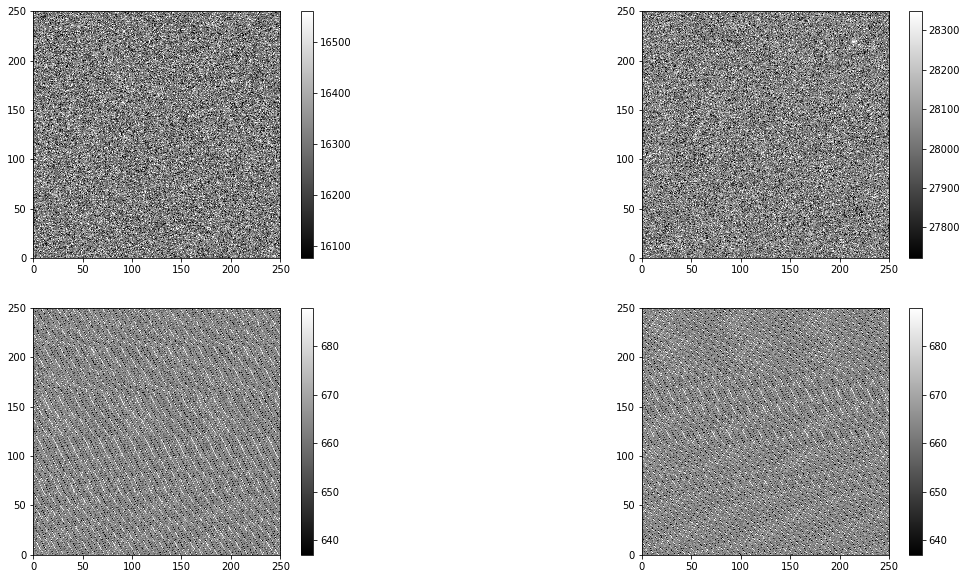

In [270]:
#CLD indexing out the appropriate regions
flat1_reg = flat1[1000:1250, 1100:1350]
flat2_reg = flat2[1000:1250, 1100:1350]

bias1_reg = bias1[1750:2000, 1750:2000]
bias2_reg = bias2[1750:2000, 1750:2000]

#CLD plotting to visually inspect again
fig, ax = plt.subplots(2,2, figsize=(20,10))
show_image(flat1_reg, cmap='gray', ax=ax[0,0], fig=fig)
show_image(flat2_reg, cmap='gray', ax=ax[0,1], fig=fig)
show_image(bias1_reg, cmap='gray', ax=ax[1,0], fig=fig)
show_image(bias2_reg, cmap='gray', ax=ax[1,1], fig=fig)
plt.show(fig)

Glad I looked at it, because it is clear that I need to choose a new region in the flats. The new regions I have choosen are x=[1100,1350] and kept y the same.

In [307]:
#CLD the first term in the numerator
f1_mean = np.mean(flat1_reg)
f2_mean = np.mean(flat2_reg)
f12_mean = f1_mean + f2_mean

#CLD the second term in the numerator
b1_mean = np.mean(bias1_reg)
b2_mean = np.mean(bias2_reg)
b12_mean = b1_mean + b2_mean

#CLD the first term denominator
diff_f = flat1_reg - flat2_reg
std_diff_f = np.std(diff_f)
sq_std_diff_f = std_diff_f ** 2

#CLD the second term denominator
diff_b = np.asarray(bias1_reg, dtype='int32') - np.asarray(bias2_reg, dtype='int32') #CLD ok so the dtype thing is 
#CLD because I was runnining into overflow errors without when calcing the differences that was giving me 
#CLD huge differences eg 65552, but chaning the dtype let's np handle it correctly for some reason?
std_diff_b = np.std(diff_b)
sq_std_diff_b = std_diff_b ** 2

In [308]:
#CLD putting together into gain equation
gain = (f12_mean - b12_mean) / (sq_std_diff_f - sq_std_diff_b)
print('The calculated gain is: %.2f' %gain)

The calculated gain is: 1.60


This is about a factor of two off (the correct answer is 2.5 $e^{-}$/ADU), but this is moderately close. I also remember from office hours that you said that the number you arrived at using Howell was incorrect as well.

# Doing some more science frames I didnt do the first time

In [18]:
data = fits.getdata(path+"a202otb.fits")
data = data / norm_master_u
fits.writeto(path+"a202otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a203otb.fits")
data = data / norm_master_u
fits.writeto(path+"a203otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a204otb.fits")
data = data / norm_master_b
fits.writeto(path+"a204otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a205otb.fits")
data = data / norm_master_b
fits.writeto(path+"a205otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a206otb.fits")
data = data / norm_master_v
fits.writeto(path+"a206otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a207otb.fits")
data = data / norm_master_v
fits.writeto(path+"a207otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a208otb.fits")
data = data / norm_master_r
fits.writeto(path+"a208otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a209otb.fits")
data = data / norm_master_r
fits.writeto(path+"a209otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a210otb.fits")
data = data / norm_master_i
fits.writeto(path+"a210otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a211otb.fits")
data = data / norm_master_i
fits.writeto(path+"a211otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a212otb.fits")
data = data / norm_master_r
fits.writeto(path+"a212otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a213otb.fits")
data = data / norm_master_r
fits.writeto(path+"a213otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a214otb.fits")
data = data / norm_master_r
fits.writeto(path+"a214otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a215otb.fits")
data = data / norm_master_v
fits.writeto(path+"a215otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a216otb.fits")
data = data / norm_master_v
fits.writeto(path+"a216otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a217otb.fits")
data = data / norm_master_v
fits.writeto(path+"a217otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a218otb.fits")
data = data / norm_master_b
fits.writeto(path+"a218otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a219otb.fits")
data = data / norm_master_b
fits.writeto(path+"a219otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a220otb.fits")
data = data / norm_master_b
fits.writeto(path+"a220otbf.fits", data, overwrite=True)

In [ ]:
data = fits.getdata(path+"a237otb.fits")
data = data / norm_master_i
fits.writeto(path+"a237otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a238otb.fits")
data = data / norm_master_i
fits.writeto(path+"a238otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a239otb.fits")
data = data / norm_master_i
fits.writeto(path+"a239otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a240otb.fits")
data = data / norm_master_i
fits.writeto(path+"a240otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a241otb.fits")
data = data / norm_master_i
fits.writeto(path+"a241otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a242otb.fits")
data = data / norm_master_i
fits.writeto(path+"a143otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a143otb.fits")
data = data / norm_master_i
fits.writeto(path+"a143otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a143otb.fits")
data = data / norm_master_i
fits.writeto(path+"a143otbf.fits", data, overwrite=True)

data = fits.getdata(path+"a143otb.fits")
data = data / norm_master_i
fits.writeto(path+"a143otbf.fits", data, overwrite=True)

In [22]:
data = fits.getdata(path+"a158otb.fits")
data = data / norm_master_v
fits.writeto(path+"a158otbf.fits", data, overwrite=True)